In [2]:
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from perlin_noise import PerlinNoise

np.random.seed(0)

In [3]:
def generate_location_mask(xpix=100, ypix=100, seed=0, weight=1, bias=0.2):
    # Perlin noise
    noise = PerlinNoise(octaves=6, seed=seed)
    mask = [noise([i/xpix, j/ypix]) for j in range(xpix) for i in range(ypix)]
    # Add bias
    f = lambda x: weight * (x + bias) if x > 0 else x
    mask = np.asarray(list(map(f, mask)))
    # Rescale so min is 0
    mask = mask + np.abs(np.min(mask))
    # Reshape back
    mask = np.reshape(mask, (xpix, ypix))
    
    return mask

In [4]:
def generate_customer_profiles_table(n_customers, mask, seed=0):
    
    np.random.seed(seed)
    
    customer_id_properties=[]
    
    # Generate possible coordinates
    space = np.shape(mask)
    loc_idx = [[i, j] for i in range(space[0]) for j in range(space[1])]
    
    # Generate customer properties from random distributions
    for customer_id in range(n_customers):
        
        # Get location from mask
        loc_id = random.choices(loc_idx, weights=mask.flatten())[0]
        x_customer_id = loc_id[0]
        y_customer_id = loc_id[1]
        
        # Customer information
        age = np.round(np.clip(np.random.gamma(8, 6), 18, 90))
        gender = random.choice([0,1])
        income = np.clip(np.random.gamma(3, 2500), 500, 20000)
        credit_score = np.round(np.clip(np.random.gamma(25, 20), 300, 850))
        
        # Transaction information
        mean_amount = income / 100
        std_amount = mean_amount / 2
        mean_nb_tx_per_day = np.random.uniform(0,4)
        
        properties = [customer_id, x_customer_id, y_customer_id, age, gender,
                      income, credit_score, mean_amount, std_amount, mean_nb_tx_per_day]
        
        customer_id_properties.append(properties)
        
    columns = ['CUSTOMER_ID', 'x_customer_id', 'y_customer_id', 'age', 'gender',
               'income', 'credit_score', 'mean_amount', 'std_amount', 'mean_nb_tx_per_day']
               
    
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=columns)
    
    return customer_profiles_table

In [5]:
def generate_terminal_profiles_table(n_terminals, mask, seed=0):
    
    np.random.seed(seed)
        
    terminal_id_properties=[]
    
    # Generate possible coordinates
    space = np.shape(mask)
    loc_idx = [[i, j] for i in range(space[0]) for j in range(space[1])]
    
    # Generate terminal properties from random distributions 
    for terminal_id in range(n_terminals):
        
        # Get location from mask
        loc_id = random.choices(loc_idx, weights=mask.flatten())[0]
        x_terminal_id = loc_id[0]
        y_terminal_id = loc_id[1]
        
        properties = [terminal_id, x_terminal_id, y_terminal_id]
        
        terminal_id_properties.append(properties)
    
    columns = ['TERMINAL_ID', 'x_terminal_id', 'y_terminal_id']
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=columns)
    
    return terminal_profiles_table

In [6]:
def get_list_terminals_within_radius(customer_profile, terminal_profiles_table, r):
    
    # Extract location data into np arrays
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    x_y_terminals = terminal_profiles_table[['x_terminal_id', 'y_terminal_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y < r)[0])
    
    # Return the list of terminal IDs
    return available_terminals

In [7]:
def generate_transactions_table(customer_profile, start_date="2020-01-01", nb_days=10):
    
    customer_transactions = []
    
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals)>0:
                        
                        terminal_id = random.choice(customer_profile.available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
    
    columns = ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT']
    customer_transactions = pd.DataFrame(customer_transactions, columns=columns)
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions = customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions  

In [8]:
def generate_dataset(n_customers = 5000, n_terminals = 10000, nb_days=180, start_date="2020-01-01", r=30, mask_size=(1000,1000)):
    
    start_time=time.time()
    mask = generate_location_mask(*mask_size)
    print("Time to generate location mask table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, mask, seed=0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, mask, seed=1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    locate_terminals = lambda x : get_list_terminals_within_radius(x, terminal_profiles_table, r=r)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(locate_terminals, axis=1)
    # With Pandarallel
    #customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_closest_terminals(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    gen_transaction = lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(gen_transaction).reset_index(drop=True)
    # With Pandarallel
    #transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)

In [9]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD'] = 0
    transactions_df['TX_FRAUD_SCENARIO'] = 0
    
    gender_weights = [1,2]
    age_groups = [(18, 25), (26, 35), (36, 50), (51, 65), (65, 90)]
    weights = [1, 5, 20, 50, 100]
    
    # Scenario 1 - microfinance fraud
    credit_score_ranges = [(800, 850), (740, 799), (670, 739), (580, 669), (300, 579)]
    
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        # Choose if men or women are targeted this day
        targeted_gender = random.choices([0,1], gender_weights)[0]
        
        # Choose targeted age group
        (lower_bound_age, upper_bound_age) = random.choices(age_groups, weights)[0]
        
        # Select range of credit score to choose from
        (lower_bound_credit, upper_bound_credit) = random.choices(credit_score_ranges, weights)[0]
        
        # Select customers in the credit score range
        customers_in_range = customer_profiles_table.loc[(customer_profiles_table.credit_score >= lower_bound_credit) &
                                                          (customer_profiles_table.credit_score < upper_bound_credit) &
                                                          (customer_profiles_table.age >= lower_bound_age) &
                                                          (customer_profiles_table.age < upper_bound_age) &
                                                          (customer_profiles_table.gender == targeted_gender)]
        
        # Select compromised customers
        compromised_customers = customers_in_range.CUSTOMER_ID.sample(n=3, random_state=day, replace=True).values
        
        # Mark their transactions for the next 7 days as compromised
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS >= day) & 
                                                    (transactions_df.TX_TIME_DAYS < day + 7) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        # Select 1/3 of these transactions as fradulent
        random.seed(day)
        nb_compromised_transactions=len(compromised_transactions)
        index_frauds = random.sample(list(compromised_transactions.index.values), k=int(nb_compromised_transactions / 3))
    
        # Multiply the fraudulent transactions' amounts by 5
        transactions_df.loc[index_frauds,'TX_AMOUNT'] = transactions_df.loc[index_frauds,'TX_AMOUNT'] * 5
        transactions_df.loc[index_frauds,'TX_FRAUD'] = 1
        transactions_df.loc[index_frauds,'TX_FRAUD_SCENARIO'] = 1
    
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: " + str(nb_frauds_scenario_1))
    
    # Scenario 2 - carding
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        # Select random terminals each day
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        
        # Mark their transactions for the next 28 days as compromised
        compromised_transactions = transactions_df[(transactions_df.TX_TIME_DAYS >= day) & 
                                                    (transactions_df.TX_TIME_DAYS < day + 28) & 
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
        
        # Select 1/3 of these transactions as fradulent
        random.seed(day)
        nb_compromised_transactions=len(compromised_transactions)
        index_frauds = random.sample(list(compromised_transactions.index.values), k=int(nb_compromised_transactions / 3))
        
        # Multiply the fraudulent transactions' amounts by 5
        transactions_df.loc[index_frauds,'TX_AMOUNT'] = transactions_df.loc[index_frauds,'TX_AMOUNT'] * 5
        transactions_df.loc[index_frauds,'TX_FRAUD'] = 1
        transactions_df.loc[index_frauds,'TX_FRAUD_SCENARIO'] = 2
    
    nb_frauds_scenario_2 = transactions_df.TX_FRAUD.sum() - nb_frauds_scenario_1
    print("Number of frauds from scenario 2: " + str(nb_frauds_scenario_2))
    
    # Scenario 3 - online fraud
    all_terminals = terminal_profiles_table.TERMINAL_ID.tolist()
    
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        # Choose if men or women are targeted this day
        targeted_gender = random.choices([0,1], gender_weights)[0]
        
        # Choose targeted age group
        (lower_bound_age, upper_bound_age) = random.choices(age_groups, weights.reverse())[0]
        
        # Select random cutomers each day
        compromised_gender = customer_profiles_table.loc[(customer_profiles_table.gender == targeted_gender) &
                                                         (customer_profiles_table.age >= lower_bound_age) &
                                                         (customer_profiles_table.age < upper_bound_age)]
        
        compromised_customers = compromised_gender.CUSTOMER_ID.sample(n=3, random_state=day).values
        
        # Mark their transactions for the next 14 days as compromised
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS >= day) & 
                                                    (transactions_df.TX_TIME_DAYS < day + 14) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        # Select 1/3 of these transactions as fradulent
        random.seed(day)
        nb_compromised_transactions=len(compromised_transactions)
        index_frauds = random.sample(list(compromised_transactions.index.values), k=int(nb_compromised_transactions / 3))
        
        # Multiply the fraudulent transactions' amounts by 5
        transactions_df.loc[index_frauds,'TX_AMOUNT'] = transactions_df.loc[index_frauds,'TX_AMOUNT'] * 5
        transactions_df.loc[index_frauds,'TX_FRAUD'] = 1
        transactions_df.loc[index_frauds,'TX_FRAUD_SCENARIO'] = 3
        
        # Change terminal to a far away one
        for idx in index_frauds:
            customer_id = transactions_df.loc[idx, 'CUSTOMER_ID']
            customer_terminals = customer_profiles_table.loc[customer_id, "available_terminals"]
            far_away_terminals = set(all_terminals) - set(customer_terminals)
            transactions_df.loc[index_frauds,'TERMINAL_ID'] = random.choice(list(far_away_terminals))
            
        
                             
    nb_frauds_scenario_3 = transactions_df.TX_FRAUD.sum() - nb_frauds_scenario_2 - nb_frauds_scenario_1
    print("Number of frauds from scenario 3: " + str(nb_frauds_scenario_3))
    
    return transactions_df       

In [10]:
# Generate Dataset
#(customer_profiles_table, terminal_profiles_table, transactions_df) = generate_dataset(n_customers = 1000, n_terminals = 2000, nb_days=10, mask_size=(100,100))
(customer_profiles_table, terminal_profiles_table, transactions_df) = generate_dataset()

Time to generate location mask table: 2.7e+01s
Time to generate customer profiles table: 4.7e+02s
Time to generate terminal profiles table: 9.8e+02s
Time to associate terminals to customers: 4.5s
Time to generate transactions: 1.1e+02s


In [11]:
# Add frauds
transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1: 2186
Number of frauds from scenario 2: 2954
Number of frauds from scenario 3: 4300


In [12]:
# Save DataFrames to files
customer_profiles_table.to_csv("./dataset/customer_profiles_table", index=False)
terminal_profiles_table.to_csv("./dataset/terminal_profiles_table", index=False)
transactions_df.to_csv("./dataset/transactions_df", index=False)

In [10]:
# Load Dataframes from files
customer_profiles_table = pd.read_csv("./dataset/customer_profiles_table", index_col="CUSTOMER_ID")
terminal_profiles_table = pd.read_csv("./dataset/terminal_profiles_table", index_col="TERMINAL_ID")
transactions_df = pd.read_csv("./dataset/transactions_df", index_col="TRANSACTION_ID")

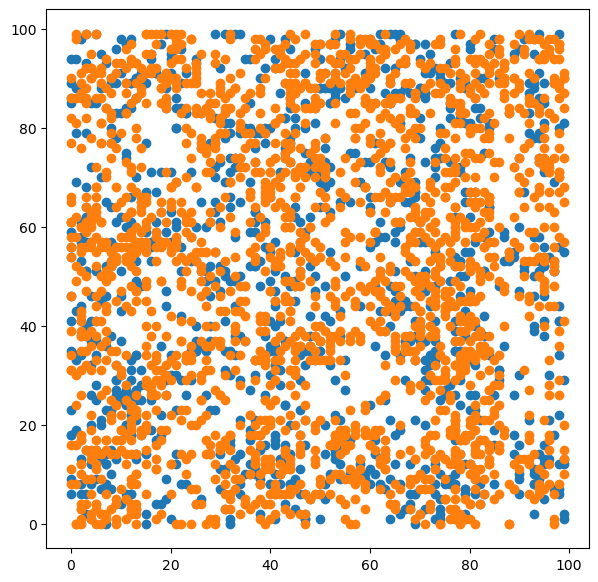

In [27]:
plt.figure(figsize=(7,7))
plt.scatter(customer_profiles_table.y_customer_id, customer_profiles_table.x_customer_id)
plt.scatter(terminal_profiles_table.y_terminal_id, terminal_profiles_table.x_terminal_id)
#plt.imshow(mask, cmap='gray')
plt.show()

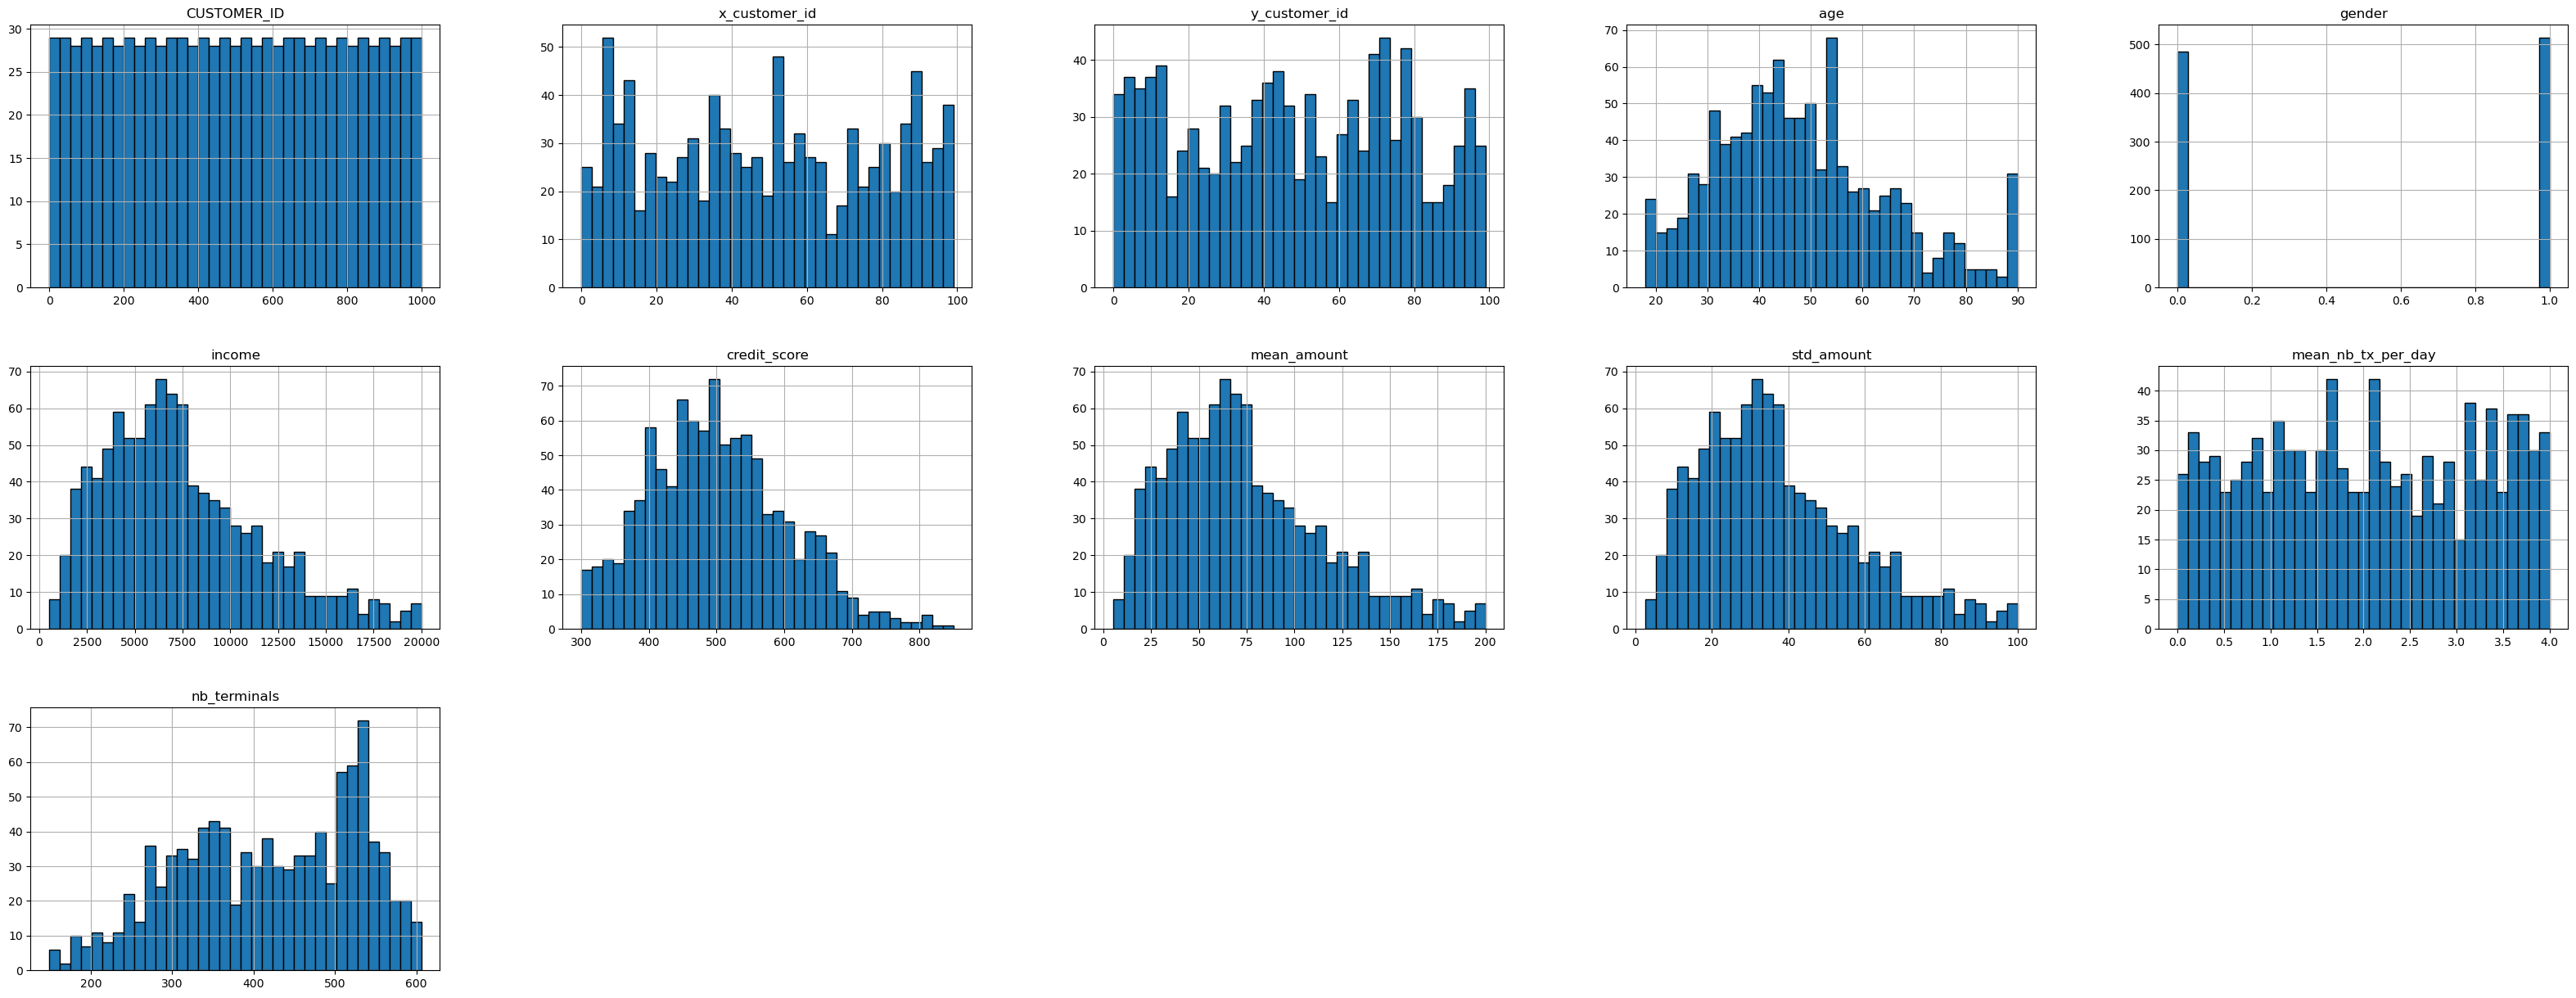

In [28]:
customer_profiles_table.hist(figsize=(40, 15), bins=35, edgecolor="black", layout=(3,5));